验证集平均 Dice 系数: 0.6274


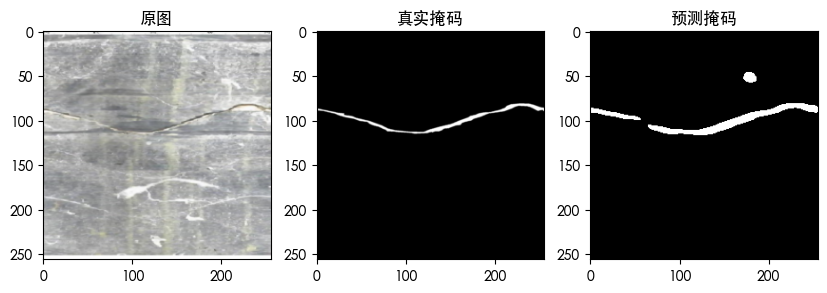

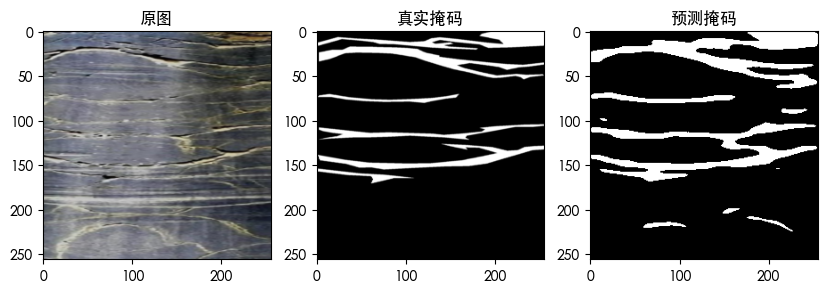

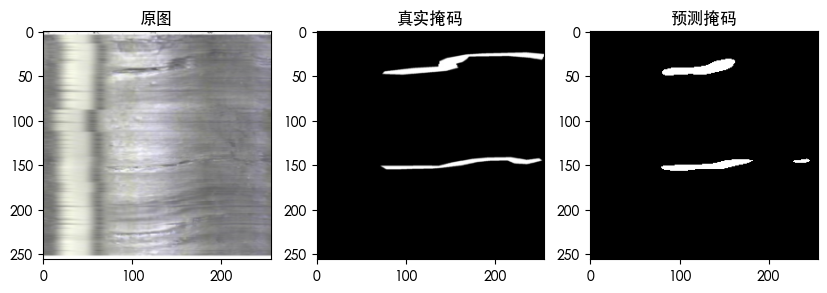

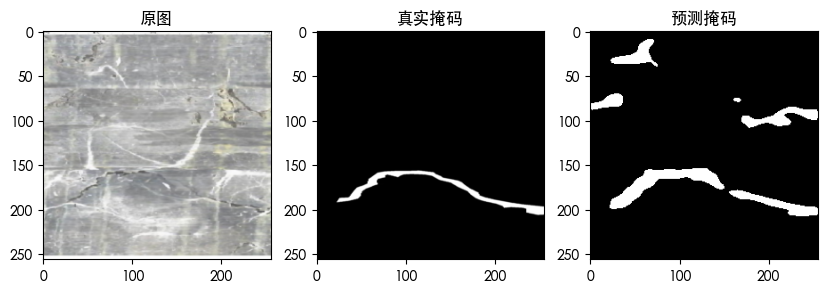

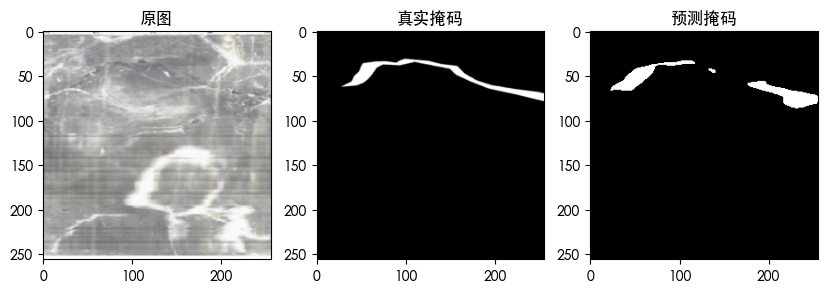

In [2]:
import torch
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp
from utils.dataset import CrackDataset
from matplotlib import font_manager as fm, rcParams

image_path = "./images/attach_1_01.jpg"

zh_fonts = [f.name for f in fm.fontManager.ttflist if any(ch in f.name for ch in ['Hei','Song','Sim'])]
if zh_fonts:
    rcParams['font.family'] = zh_fonts[0]  # 使用找到的第一个中文字体
else:
    print("系统中未找到中文字体，中文可能无法显示")


# 模型和设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = smp.Unet(encoder_name="resnet34", encoder_weights=None, in_channels=3, classes=1)
model.load_state_dict(torch.load('./checkpoints/unet_crack.pth', map_location=device))
model.to(device)
model.eval()

# 数据预处理
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# 验证集路径
val_images_dir = './images'
val_masks_dir = './masks'

dataset = CrackDataset(images_dir=val_images_dir, masks_dir=val_masks_dir, transform=transform, denoise=True)
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

# 评价指标函数
def dice_coefficient(pred, target, smooth=1.0):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

# 验证循环
dice_scores = []
for img, mask in loader:
    img, mask = img.to(device), mask.to(device)
    with torch.no_grad():
        pred = torch.sigmoid(model(img))
        pred_binary = (pred > 0.5).float()
        dice = dice_coefficient(pred_binary, mask)
        dice_scores.append(dice.item())

print(f"验证集平均 Dice 系数: {sum(dice_scores)/len(dice_scores):.4f}")

# 可视化前5张预测
import matplotlib.pyplot as plt

for i in range(min(5, len(dataset))):
    img, mask = dataset[i]
    img_tensor = img.unsqueeze(0).to(device)
    with torch.no_grad():
        pred = torch.sigmoid(model(img_tensor))
        pred_mask = (pred.squeeze().cpu().numpy() > 0.5).astype('uint8') * 255
    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plt.title("原图")
    plt.imshow(img.permute(1,2,0))
    plt.subplot(1,3,2)
    plt.title("真实掩码")
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.subplot(1,3,3)
    plt.title("预测掩码")
    plt.imshow(pred_mask, cmap='gray')
    plt.show()


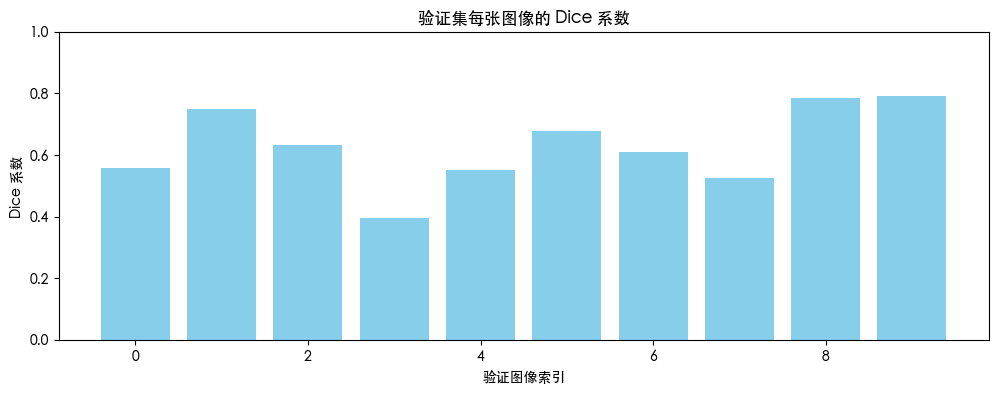

验证集平均 Dice 系数: 0.6274


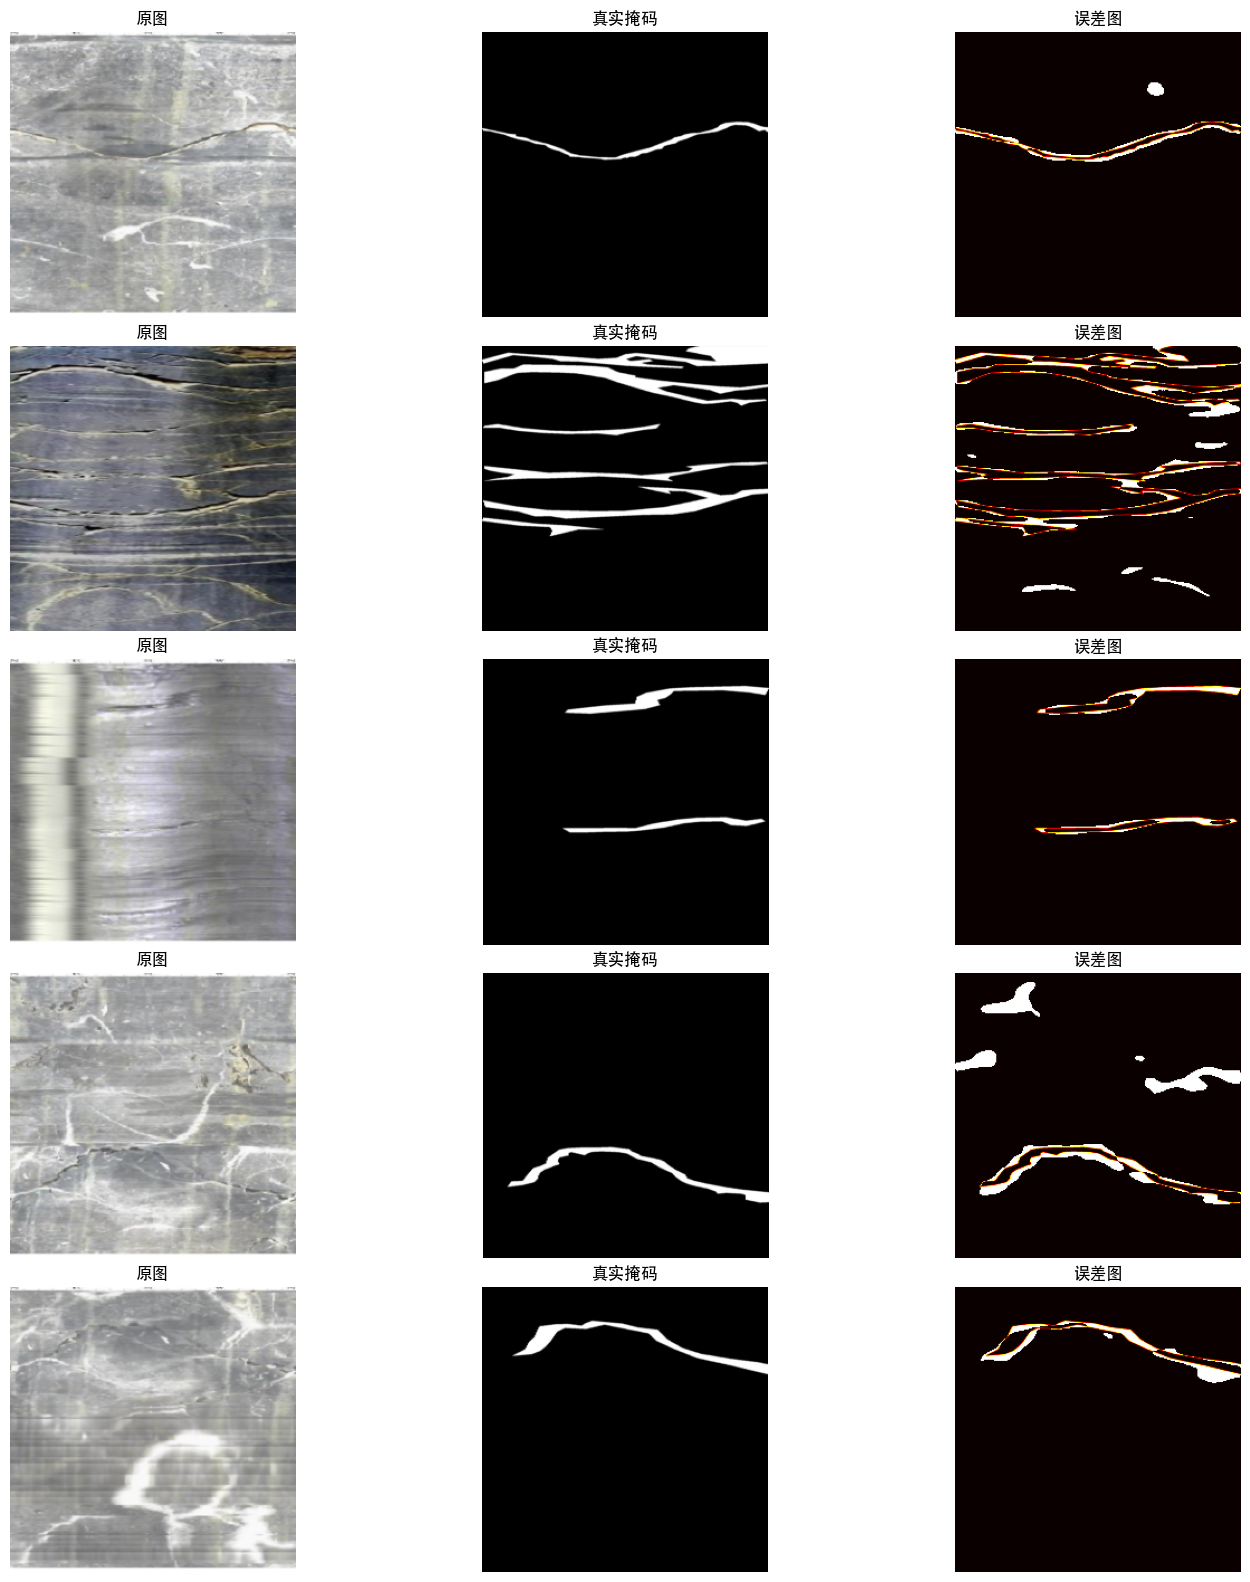

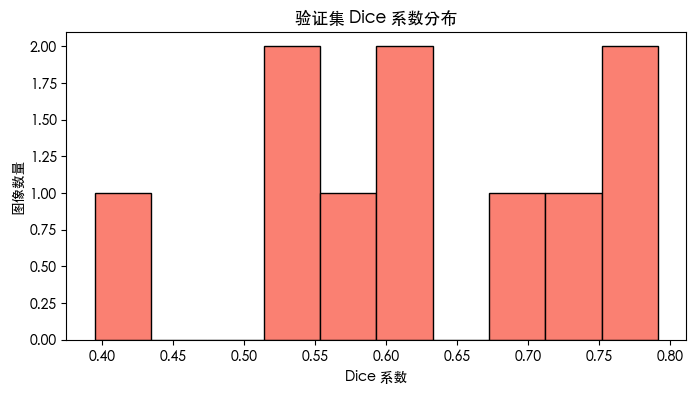

In [5]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp
from utils.dataset import CrackDataset, denoise_image

# --- 参数设置 ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = './checkpoints/unet_crack.pth'
val_images_dir = './images'
val_masks_dir = './masks'

# --- 数据预处理 ---
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset = CrackDataset(images_dir=val_images_dir, masks_dir=val_masks_dir, transform=transform, denoise=True)
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

# --- 模型加载 ---
model = smp.Unet(encoder_name="resnet34", encoder_weights=None, in_channels=3, classes=1)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# --- 定义 Dice 系数 ---
def dice_coefficient(pred, target, smooth=1.0):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

# --- 验证循环 ---
dice_scores = []
errors = []

for idx, (img, mask) in enumerate(loader):
    img, mask = img.to(device), mask.to(device)
    with torch.no_grad():
        pred = torch.sigmoid(model(img))
        pred_binary = (pred > 0.5).float()
        dice = dice_coefficient(pred_binary, mask)
        dice_scores.append(dice.item())
        errors.append((mask - pred_binary).cpu().numpy().squeeze())

# --- 1. Dice 系数柱状图 ---
plt.figure(figsize=(12,4))
plt.bar(range(len(dice_scores)), dice_scores, color='skyblue')
plt.xlabel('验证图像索引')
plt.ylabel('Dice 系数')
plt.title('验证集每张图像的 Dice 系数')
plt.ylim(0,1)
plt.show()

# --- 2. 平均 Dice 系数 ---
print(f"验证集平均 Dice 系数: {np.mean(dice_scores):.4f}")

# --- 3. 随机选择几张图可视化预测与误差 ---
num_visual = min(5, len(dataset))

fig, axes = plt.subplots(num_visual, 3, figsize=(18, 4*num_visual))
plt.subplots_adjust(wspace=0.05, hspace=0.1)  # 缩小水平和垂直间距

for i in range(num_visual):
    img, mask = dataset[i]
    img_tensor = img.unsqueeze(0).to(device)
    with torch.no_grad():
        pred = torch.sigmoid(model(img_tensor))
        pred_mask = (pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8) * 255
    error_map = np.abs(mask.squeeze().numpy() - pred_mask/255)

    # 原图
    ax = axes[i, 0]
    ax.imshow(img.permute(1,2,0))
    ax.set_title('原图', fontsize=12)
    ax.axis('off')

    # 真实掩码
    ax = axes[i, 1]
    ax.imshow(mask.squeeze(), cmap='gray')
    ax.set_title('真实掩码', fontsize=12)
    ax.axis('off')

    # 误差图
    ax = axes[i, 2]
    ax.imshow(error_map, cmap='hot')
    ax.set_title('误差图', fontsize=12)
    ax.axis('off')

plt.show()

# --- 4. Dice 系数分布直方图 ---
plt.figure(figsize=(8,4))
plt.hist(dice_scores, bins=10, color='salmon', edgecolor='black')
plt.xlabel('Dice 系数')
plt.ylabel('图像数量')
plt.title('验证集 Dice 系数分布')
plt.show()
